### Let's start with downloading the raw data

In [1]:
import sys
import os
# to reach the dataloader_functions module
module_path = os.path.abspath(os.path.join( ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader_functions.download_data import download_raw_data
current_dir = os.getcwd()

In [2]:
### TODO update this section per dataset
dataset_config = {
    'dataset_name': 'consumer_complaints',
    'source': 'kaggle', # ['kaggle', 'local', 'openml', 'hf']
    'remote_path': 'selener/consumer-complaint-database',
    'files': ['rows.csv'],
    'rename_files': ['complaints_data.csv'],
    'task': 'clf', # ['reg', 'clf']
    'target': 'Company response to consumer',
}

In [3]:
if dataset_config['task'] == 'clf':
    dataset_subfolder = os.path.join('raw', 'classification', dataset_config['dataset_name']) 
elif dataset_config['task'] == 'reg':
    dataset_subfolder = os.path.join('raw', 'regression', dataset_config['dataset_name'])
else:
    raise ValueError(f"Unknown task: {dataset_config['task']}")

# this path needs to be modified based on the location of the notebook
download_path = os.path.join(current_dir, '..', '..', 'datasets_files', dataset_subfolder)

if download_raw_data(
    dataset_config=dataset_config,
    download_path=download_path,
    force_download=False,
    remove_unlisted=True,
) is not None:
    print(f"Downloaded {dataset_config['dataset_name']} dataset to {download_path}")

Info: Dataset already downloaded in /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/classification/../../datasets_files/raw/classification/consumer_complaints.
Downloaded consumer_complaints dataset to /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/classification/../../datasets_files/raw/classification/consumer_complaints


### Now we need to preprocess the data

In [4]:
from dataloader_functions.load_and_pp_raw_data import _drop_empty_columns, _drop_single_value_columns
from dataloader_functions.utils.data_2_df import read_any_to_df
import pandas as pd

import os
current_dir = os.getcwd()

In [5]:
# TODO: we will downsample the dataset to ~24k samples

import os
import pandas as pd

# Define the path
current_dir = os.getcwd()
download_path = os.path.join(current_dir, '..', '..', 'datasets_files', dataset_subfolder)
                                                                                                                    
# File paths
train_path = os.path.join(download_path, dataset_config['rename_files'][0])

# Load safely, skipping bad lines
train_df = pd.read_csv(train_path, on_bad_lines='skip', engine='python')

# Downsample with fallback if not enough rows
train_sample_size = min(len(train_df), 24000)

train_df = train_df.sample(n=train_sample_size, random_state=42).reset_index(drop=True)

# Save back (overwrite the originals)
train_df.to_csv(train_path, index=False)


In [6]:

dataset_files_df = []

if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for file in dataset_config['rename_files']:

    file_location = os.path.join(download_path, file)

    print(f"Loading {file_location}")

    dataset_files_df.append(read_any_to_df(file_location))

# example of the loaded df data:
pd.set_option('display.max_columns', None)
dataset_files_df[0].head(n=3)

Loading /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/classification/../../datasets_files/raw/classification/consumer_complaints/complaints_data.csv


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,01/31/2019,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,NaN,Company has responded to the consumer and the ...,"WAKEFIELD & ASSOCIATES, INC.",GA,30014,NaN,Consent not provided,Web,01/31/2019,Closed with explanation,Yes,NaN,3139423
1,08/04/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Specialized Loan Servicing LLC,VA,22042,NaN,NaN,Referral,08/06/2014,Closed with explanation,Yes,Yes,967089
2,09/09/2014,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,NATIONSTAR MORTGAGE,DC,20003,NaN,NaN,Postal mail,09/12/2014,Closed with explanation,Yes,No,1020500


In [7]:
## Run some basic data cleaning

dataset_files_gen_cleaned = []
missing_ratio_threshold = 0.5 # TODO the threshold can be changed

for df_file in dataset_files_df:
    df_size = df_file.shape
    # 1. Drop columns with more than 50% missing values
    df_file = _drop_empty_columns(df_file, threshold=missing_ratio_threshold)   
    # 2. Drop columns with only one unique value
    df_file = _drop_single_value_columns(df_file)
    # 3. remove duplicates
    df_file = df_file.drop_duplicates()
    # 4. remove rows with missing target values
    df_file = df_file[df_file[dataset_config['target']].notna()]
    # 5. drop unnamed columns
    df_file = df_file.loc[:, ~df_file.columns.str.contains('^Unnamed')]

    dataset_files_gen_cleaned.append(df_file)

    print(f"Dataframe shape before/afrer cleaning: {df_size} / {df_file.shape}")

Dropped: Index(['Consumer complaint narrative', 'Company public response', 'Tags'], dtype='object')
Dataframe shape before/afrer cleaning: (24000, 18) / (24000, 15)


In [8]:
## TODO: Now run custom data cleaning -> remove non-essential columns

cols_to_drop = ['Complaint ID','Date sent to company','Timely response?','Consumer disputed?']

dataset_files_cleaned = []

# assuming for multiple files we still want to drop the same columns
for df_file in dataset_files_gen_cleaned:
    df_size = df_file.shape
    for col in cols_to_drop:
        if col in df_file.columns:
            df_file.drop(col, axis=1, inplace=True)
        else:
            print(f"Column {col} not found in dataframe")

    dataset_files_cleaned.append(df_file)    
    print(f"Dataframe shape before/afrer by-hand cleaning: {df_size} / {df_file.shape}")

dataset_files_cleaned[0].head(n=3)

Dataframe shape before/afrer by-hand cleaning: (24000, 15) / (24000, 11)


,Date received,Product,Sub-product,Issue,Sub-issue,Company,State,ZIP code,Consumer consent provided?,Submitted via,Company response to consumer
0,01/31/2019,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,"WAKEFIELD & ASSOCIATES, INC.",GA,30014,Consent not provided,Web,Closed with explanation
1,08/04/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,Specialized Loan Servicing LLC,VA,22042,NaN,Referral,Closed with explanation
2,09/09/2014,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NATIONSTAR MORTGAGE,DC,20003,NaN,Postal mail,Closed with explanation


In [9]:
# TODO: some custom data cleaning
import copy 
import pandas as pd
import numpy as np
from  dataloader_functions.load_and_pp_raw_data import clean_zip_code

tmp_df = copy.deepcopy(dataset_files_cleaned)
dataset_files_by_hand_cleaned = []

for df_file in dataset_files_cleaned:
    print(f"Dataframe shape before custom cleaning: {df_file.shape}")
    
    # 1. Drop non-essential target categories & make safe copy
    to_drop = ['Closed', 'In progress', 'Untimely response', 'Closed with relief']
    df_file = df_file[~df_file[dataset_config['target']].isin(to_drop)].copy()

    # 2. Convert 'Date received' to timestamp (handle NaT safely)
    df_file['Date received'] = pd.to_datetime(df_file['Date received'], format='%m/%d/%Y', errors='coerce')
    df_file['Date received'] = df_file['Date received'].apply(lambda x: x.timestamp() if pd.notnull(x) else float('nan'))

    # 3. Clean 'ZIP code' column to remove non-numerical characters
    if 'ZIP code' in df_file.columns:
        df_file['ZIP code'] = clean_zip_code(df_file['ZIP code'])

    print(f"Dataframe shape after custom cleaning: {df_file.shape}")

    dataset_files_by_hand_cleaned.append(df_file)

# reset the dataframe list to the version before custom cleaning
dataset_files_cleaned = tmp_df

Dataframe shape before custom cleaning: (24000, 11)
Dataframe shape after custom cleaning: (23273, 11)


### Now it is time to visualize our changes

In [10]:
pd.set_option('display.max_columns', None)

dataset_files_by_hand_cleaned[0].head(n=3)

,Date received,Product,Sub-product,Issue,Sub-issue,Company,State,ZIP code,Consumer consent provided?,Submitted via,Company response to consumer
0,1.548893e+09,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,"WAKEFIELD & ASSOCIATES, INC.",GA,300,Consent not provided,Web,Closed with explanation
1,1.407110e+09,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,Specialized Loan Servicing LLC,VA,220,NaN,Referral,Closed with explanation
2,1.410221e+09,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NATIONSTAR MORTGAGE,DC,200,NaN,Postal mail,Closed with explanation


Let's figure out which columns should be viewed as categorical / numerical / textual

we can start with a simple heuristic:
1. numerical is everything which
    - keeps most of its character length after non-numeral strip
    - has about the same number of unique values after the strip
    + for the purpose of keeping "semantic information", hand picked columns can be viewed also as non-numerical, that is not the default benchmark approach though

2. categorical is everthing non numerical, which can be then divided into N (where N << Num instances) unique categories

3. textual is everything else

In [11]:
import pandas as pd
import re

def is_mostly_numeric(series, length_threshold=0.5, unique_threshold=0.8):
    """Check if column is mostly numeric after stripping non-numeric chars."""
    stripped = series.astype(str).str.replace(r"[^\d\.\-]", "", regex=True)
    
    original_len = series.astype(str).str.len().replace(0, 1)  # avoid div by zero
    length_ratio = (stripped.str.len() / original_len).mean()

    unique_ratio = stripped.nunique(dropna=False) / max(series.nunique(dropna=False), 1)

    return length_ratio > length_threshold and unique_ratio > unique_threshold

def classify_columns(df, unique_ratio_threshold=None, explicit_nunique_threshold=None):
    """
    Classify dataframe columns into numerical, categorical, textual.
    - Binary categorical (2 unique values) is considered categorical.
    """
    n_rows = len(df)

    # Determine threshold for categorical vs textual
    if explicit_nunique_threshold is not None:
        nunique_threshold = explicit_nunique_threshold
    elif unique_ratio_threshold is not None:
        nunique_threshold = int(unique_ratio_threshold * n_rows)
    else:
        nunique_threshold = int(0.05 * n_rows)  # default 5%

    nunique_threshold = max(10, nunique_threshold)  # safeguard
    print(f"Threshold for categorical vs textual: {nunique_threshold}")

    numerical_cols = []
    categorical_cols = []
    textual_cols = []

    for col in df.columns:
        series = df[col]
        nunique = series.nunique(dropna=False)

        if pd.api.types.is_numeric_dtype(series):
            if nunique <= nunique_threshold:
                categorical_cols.append(col)
            else:
                numerical_cols.append(col)
        
        elif pd.api.types.is_string_dtype(series) or pd.api.types.is_object_dtype(series):
            if is_mostly_numeric(series):
                numerical_cols.append(col)
            else:
                if nunique <= nunique_threshold:
                    categorical_cols.append(col)
                else:
                    textual_cols.append(col)
        else:
            print(f"⚠️ Unhandled column type: '{col}' (dtype={series.dtype})")

    print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
    print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
    print(f"Textual columns ({len(textual_cols)}): {textual_cols}")

    return numerical_cols, categorical_cols, textual_cols

# Example usage:
for df_file in dataset_files_by_hand_cleaned:
    # Ratio-based (5% of rows)
    # umerical_cols, categorical_cols, textual_cols = classify_columns(df_file, unique_ratio_threshold=0.05)
    print("")
    # OR explicit value (e.g., anything <= 50 is categorical)
    numerical_cols, categorical_cols, textual_cols = classify_columns(df_file, explicit_nunique_threshold=50)



Threshold for categorical vs textual: 50
Numerical columns (2): ['Date received', 'ZIP code']
Categorical columns (4): ['Product', 'Consumer consent provided?', 'Submitted via', 'Company response to consumer']
Textual columns (5): ['Sub-product', 'Issue', 'Sub-issue', 'Company', 'State']


Now let's just try to visualize the kept features, their example values, and their cat/num/text allocation

In [12]:
summary = []
for col in df_file.columns:
    if col in categorical_cols:
        col_type = "categorical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in textual_cols:
        col_type = "textual"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in numerical_cols:
        col_type = "numerical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = '~ ' + str(num_categories) + ' ~'
    else:
        col_type = "unknown"
        num_categories_display = '--'

    example = df_file[col].dropna().iloc[0] if df_file[col].dropna().size > 0 else None
    summary.append({
        'Column Name': col,
        'Example Value': str(example),
        'Type': col_type,
        '# Categories': num_categories_display
    })

summary_df = pd.DataFrame(summary)

# TODO: by hand changes of the type and category count -> e.g. for 'Location':
#    # Post-processing: override the type and category count for 'Location'
#    # summary_df.loc[summary_df['Column Name'] == 'Location', 'Type'] = 'textual'
#    # num_categories = df_file['Location'].nunique(dropna=True)
#    # summary_df.loc[summary_df['Column Name'] == 'Location', '# Categories'] = int(num_categories)

display(summary_df)  # Or print(summary_df)


,Column Name,Example Value,Type,# Categories
0,Date received,1548892800.0,numerical,~ 2589 ~
1,Product,Debt collection,categorical,18
2,Sub-product,I do not know,textual,71
3,Issue,Attempts to collect debt not owed,textual,154
4,Sub-issue,Debt is not yours,textual,201
5,Company,"WAKEFIELD & ASSOCIATES, INC.",textual,1318
6,State,GA,textual,60
7,ZIP code,300,numerical,~ 841 ~
8,Consumer consent provided?,Consent not provided,categorical,4
9,Submitted via,Web,categorical,6


### Saving the processed data and loading it back up

In [13]:
import os
import pandas as pd

# Handle rename_files fallback
if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for i, df_file in enumerate(dataset_files_by_hand_cleaned):
    df_with_meta = df_file.copy()

    # Get corresponding file name
    file_name = dataset_config['rename_files'][i]
    file_base = os.path.splitext(file_name)[0]

    # Try assigning multi-index header from summary
    try:
        df_with_meta.columns = pd.MultiIndex.from_frame(
            summary_df[['Column Name', 'Type', '# Categories']]
        )
        local_summary = summary_df.copy()
    except ValueError:
        local_summary = summary_df.copy()
        if dataset_config['target'] in local_summary['Column Name'].values:
            local_summary = local_summary[local_summary['Column Name'] != dataset_config['target']]
            df_with_meta.columns = pd.MultiIndex.from_frame(
                local_summary[['Column Name', 'Type', '# Categories']]
            )
        else:
            raise

    # Construct and save everything together
    output_filename = f"{file_base}_processed.pkl"
    output_path = os.path.join(download_path, output_filename)

    save_bundle = {
        'data': df_with_meta,
        'summary': local_summary,
        'config': dataset_config
    }

    pd.to_pickle(save_bundle, output_path)
    print(f"Saved: {output_path}")


Saved: /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/classification/../../datasets_files/raw/classification/consumer_complaints/complaints_data_processed.pkl


In [14]:
import os
import pandas as pd

# Loop through processed files in rename_files
for file_name in dataset_config['rename_files']:
    # Remove .csv or .tsv extension to get the base name
    file_base = os.path.splitext(file_name)[0]
    processed_filename = f"{file_base}_processed.pkl"
    processed_path = os.path.join(download_path, processed_filename)

    # Load the bundled dictionary (data + summary + config)
    bundle = pd.read_pickle(processed_path)

    # Extract components
    loaded_df = bundle['data']
    summary_df = bundle['summary']
    loaded_config = bundle['config']

    print(f"\n=== {file_base.upper()} ===")
    print(f"Loaded config keys: {list(loaded_config.keys())}")

    # Show metadata
    meta_df = pd.DataFrame(loaded_df.columns.tolist(), columns=['Column Name', 'Type', '# Categories'])
    display(meta_df)

    # Flatten for modeling
    loaded_df.columns = loaded_df.columns.get_level_values(0)
    display(loaded_df.head(n=3))



=== COMPLAINTS_DATA ===
Loaded config keys: ['dataset_name', 'source', 'remote_path', 'files', 'rename_files', 'task', 'target']


,Column Name,Type,# Categories
0,Date received,numerical,~ 2589 ~
1,Product,categorical,18
2,Sub-product,textual,71
3,Issue,textual,154
4,Sub-issue,textual,201
5,Company,textual,1318
6,State,textual,60
7,ZIP code,numerical,~ 841 ~
8,Consumer consent provided?,categorical,4
9,Submitted via,categorical,6


Column Name,Date received,Product,Sub-product,Issue,Sub-issue,Company,State,ZIP code,Consumer consent provided?,Submitted via,Company response to consumer
0,1.548893e+09,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,"WAKEFIELD & ASSOCIATES, INC.",GA,300,Consent not provided,Web,Closed with explanation
1,1.407110e+09,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,Specialized Loan Servicing LLC,VA,220,NaN,Referral,Closed with explanation
2,1.410221e+09,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NATIONSTAR MORTGAGE,DC,200,NaN,Postal mail,Closed with explanation


### Bonus insights

Unique classes in 'Company response to consumer': ['Closed with explanation', 'Closed with non-monetary relief', 'Closed with monetary relief', 'Closed without relief']


Text(0.5, 1.0, "Distribution of 'Company response to consumer' target")

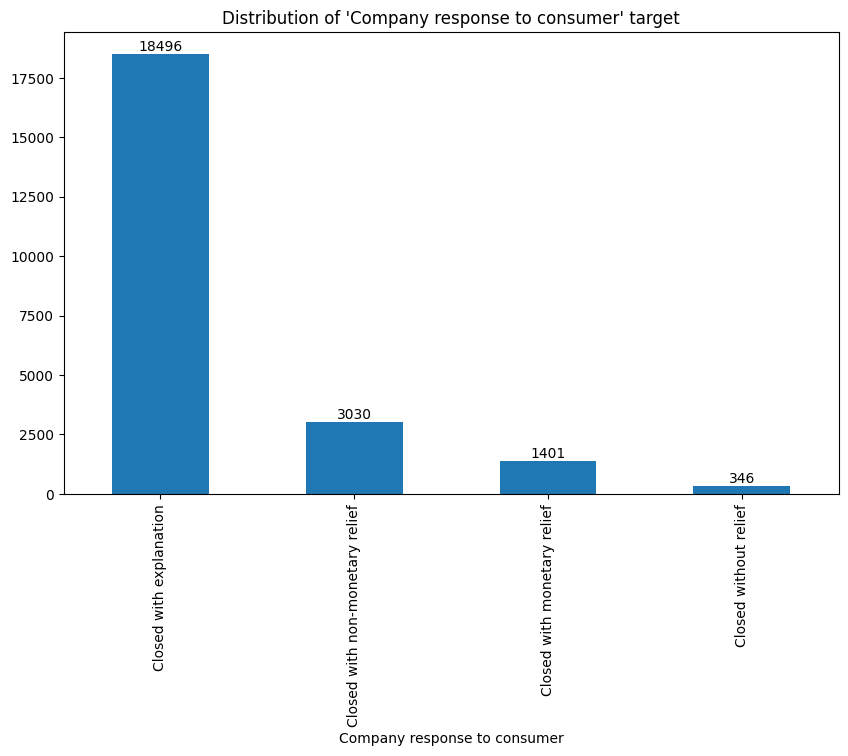

In [15]:
# show data imbalance:
import matplotlib.pyplot as plt

# Plot the distribution of player_class with counts
value_counts = loaded_df[dataset_config['target']].value_counts()

# print the unique classes
print(f"Unique classes in '{dataset_config['target']}': {value_counts.index.tolist()}")

plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')

# Add counts as text labels on top of bars
for i, count in enumerate(value_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.title(f"Distribution of '{dataset_config['target']}' target")

In [16]:
from baseline_eval import evaluate_baseline, plot_model_performance_summary
results = evaluate_baseline(
    df=loaded_df,
    model='AGTabular',
    df_name=dataset_config['dataset_name'],
    label_col= dataset_config['target'],
    task_type=dataset_config['task'],
    textual_cols=textual_cols,
    k_folds=5,
    seed=0,
    max_samples=3000,
    output_path=f"../../baseline_results/{dataset_config['task']}/{dataset_config['dataset_name']}.csv"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250521_170609"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #53~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Jan 15 19:18:46 UTC 2
CPU Count:          64
Memory Avail:       333.40 GB / 503.54 GB (66.2%)
Disk Space Avail:   33801.88 GB / 51214.59 GB (66.0%)
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1



[WRAPPER] Running stratified downsampling mode for task: clf
Info: 
[INFO] Downsampling dataframe: consumer_complaints (original rows: 23273)
Info: Trying to sample ~750 rows per class (total=3000)
Info: [INFO] Class Closed without relief has only 346 instances. Keeping all.
Info: Final downsampled dataset has 3000 rows. Per class counts: [Closed with explanation: 1097, Closed with non-monetary relief: 796, Closed with monetary relief: 761, Closed without relief: 346]

Downsampled 3000 rows for consumer_complaints dataset.


Beginning AutoGluon training ... Time limit = 360s
AutoGluon will save models to "/home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/classification/AutogluonModels/ag-20250521_170609"
Train Data Rows:    2400
Train Data Columns: 10
Label Column:       Company response to consumer
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 4
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
Cannot interpret 'Int64Dtype()' as a data type
	Available Memory:                    341395.14 MB
	Train Data (Original)  Memory Usage: 1.32 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
Cannot interpret 'Int64Dtype()' as a data type
Cannot interpret 'Int64Dtype()' as a data type
Cannot interpret 'Int64Dtype()' as a data type
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
Cannot interpret 'Int64Dtype()' as

In [17]:
rs = pd.read_csv(f"../../baseline_results/{dataset_config['task']}/{dataset_config['dataset_name']}.csv")
plot_model_performance_summary(name=dataset_config['dataset_name'],task=dataset_config['task'], df=rs)

Saving plot to ../../baseline_results/plots/clf/score
Saving plot to ../../baseline_results/plots/clf/loss
Saving plot to ../../baseline_results/plots/clf/roc_auc


{'score':                                     mean       std
 model                                             
 AutoGluon_Tabular_without_text  0.629667  0.024364
 AutoGluon_Tabular_with_text     0.679000  0.010967,
 'loss':                                     mean       std
 model                                             
 AutoGluon_Tabular_with_text     0.810386  0.046411
 AutoGluon_Tabular_without_text  0.818811  0.026589,
 'roc_auc':                                     mean       std
 model                                             
 AutoGluon_Tabular_without_text  0.845981  0.013781
 AutoGluon_Tabular_with_text     0.876902  0.012650}